In [144]:
%matplotlib inline

import json
import numpy as np
import pandas as pd
from os import listdir, path
from collections import defaultdict, Counter
from whotracksme.data import load_tracker_db, DataSource
from whotracksme.data.db import create_tracker_map

There are two parts:
* A tracker database, which has a useful wrapper method create_tracker_map 
* A series of csvs in folders by month, and by region

### The database

In [2]:
db = load_tracker_db()
db

In [3]:
def list_tables_in_db(db):
    return db.cursor().execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

list_tables_in_db(db)

[('categories',),
 ('companies',),
 ('iab_vendors',),
 ('tracker_domains',),
 ('trackers',),
 ('truste_companies',),
 ('urls',)]

In [4]:
tracker_info = create_tracker_map(db)
list(tracker_info['trackers'].keys())[0:5]

['google_analytics',
 'doubleclick',
 'google',
 'googleapis.com',
 'google_tag_manager']

In [5]:
tracker_info['trackers']['google_tag_manager']

{'id': 'google_tag_manager',
 'name': 'Google Tag Manager',
 'category': 'essential',
 'website_url': 'https://marketingplatform.google.com/about/tag-manager/',
 'ghostery_id': '1283',
 'company_id': 'google',
 'iab_vendor': None,
 'truste_type': None,
 'description': None,
 'privacy_url': 'http://www.google.com/intl/en/policies/privacy/',
 'domains': ['googletagmanager.com', 'googletagservices.com']}

In [6]:
list(tracker_info['trackers'].keys())[-5:]

['adobe_login', 'runmewivel.com', 'turner', 'digital.gov', 'datatables']

In [7]:
tracker_info['trackers']['turner']

{'id': 'turner',
 'name': 'Turner',
 'category': 'cdn',
 'website_url': 'https://www.turner.com/',
 'ghostery_id': None,
 'company_id': 'turner',
 'iab_vendor': None,
 'truste_type': None,
 'description': None,
 'privacy_url': 'https://www.turner.com/legal#PrivacyPolicy',
 'domains': ['turner.com']}

Interesting to note the ghostery_id in here

### The data files

In [8]:
ls whotracksme/data/assets

2017-05/  2017-08/  2017-11/  2018-02/  2018-05/  2018-08/
2017-06/  2017-09/  2017-12/  2018-03/  2018-06/  2018-09/
2017-07/  2017-10/  2018-01/  2018-04/  2018-07/  trackerdb.sql


In [9]:
ls whotracksme/data/assets/2018-09/

de/  eu/  fr/  global/  us/


In [10]:
ls whotracksme/data/assets/2017-05

global/


Not all directories have the data split out by country. To keep things comparable across months, I'm guessing I need to load in the data from all the geo directories and add together.

In [11]:
ls whotracksme/data/assets/2017-05/global/

companies.csv  domains.csv  sites.csv  sites_trackers.csv  trackers.csv


In [12]:
ls whotracksme/data/assets/2018-09/de/

companies.csv  domains.csv  sites.csv  sites_trackers.csv  trackers.csv


All directories have the same five tables. This is all consistent with their own readme.

The data is created by aggregating data about page loads at several different levels. These aggregated stats are published in the following files:

    domains.csv: Top third-party domains seen tracking.
    trackers.csv: Top trackers - this combines domains known be operated by the same tracker.
    companies.csv: Top companies - aggregates the stats for trackers owned by the same company.
    sites.csv: Stats for number of trackers seen on popular websites.
    site_trackers.csv: Stats for each tracker on each site.

We calculate a standard set of signals across all aggregations:

    cookies: Proportion of pages where a cookie was sent by the browser, or a Set-Cookie header was returned by the tracker's server. Float between 0 and 1.
    bad_qs: Proportion of pages where a unique identifier was detected in the query string parameters sent with a request to this tracker. The methodology for this detection can be found in our paper. Float between 0 and 1.
    tracked: Proportion of pages where a unique identifier transmission was detected, either via cookies or bad_qs. Float between 0 and 1.
    https: Proportion of pages where the tracker only used HTTPS traffic. Float between 0 and 1.
    requests: Average number of requests made to the tracker per page. Positive float.
    requests_tracking: Average number of requests made to the tracker with tracking (cookie or query string) per page. Positive float.
    content_length: Average of Content-Length headers received per page. This is an approximate measure of the bandwidth usage of the tracker. Positive float.
    requests_failed: Average number of requests make to the tracker per page which do not succeed. This is an approximate measure of blocking from external sources (i.e. adblocking extensions or firewalls). Positive float.
    has_blocking: Proportion of pages where some kind of external blocking of the tracker was detected. Float between 0 and 1.

There are also signals for the frequency with which certain resource types are loaded by third-parties:

    script: Javascript code (via a <script> tag or web worker).
    iframe: A subdocument (via <frame> or <iframe> elements).
    beacon: Requests sent through the Beacon API.
    image: Image and imageset resources.
    stylesheet: CSS files.
    font: Custom fonts.
    xhr: Requests made from scripts via the XMLHttpRequest or fetch APIs.
    plugin: Requests of object or object_subrequest types, which are typically associated with browser plugins such as Flash.
    media: Requests loaded via <video> or <audio> HTML elements.

We also count the presences of other entities in the aggregation. This enables us to, for example, count how many of a tracker's domains they use simultaneously on average, or how many different trackers and companies are usually present on sites:

    hosts
    trackers
    companies

For domain, trackers and companies aggregations we also include two extra measures:

    reach: Proportional presence across all page loads (i.e. if a tracker is present on 50 out of 1000 page loads, the reach would be 0.05). Value is a float between 0 and 1.
    site_reach: Presence across unique first party sites. e.g. if a tracker is present on 10 sites, and we have 100 different sites in the database, the site reach is 0.1. Value is a float between 0 and 1.

The files are organised monthly with the following structure: assets/{month}/{country}/{file}.csv

In [13]:
asset_root = 'whotracksme/data/assets'
regions = set()
months = set()
file_names = set()
asset_paths = defaultdict(list)

In [14]:
for d in listdir(asset_root):
    if path.isdir(path.join(asset_root, d)):
        months.add(d)
months

{'2017-05',
 '2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09'}

In [15]:
for month in months:
    month_path = path.join(asset_root, month)
    for d in listdir(month_path):
        if path.isdir(path.join(month_path, d)):
            regions.add(d)
regions

{'de', 'eu', 'fr', 'global', 'us'}

In [16]:
for month in months:
    for region in regions:
        end_path = path.join(asset_root, month, region)
        if path.isdir(end_path):
            for file in listdir(end_path):
                file_names.add(file)
file_names

{'companies.csv',
 'domains.csv',
 'sites.csv',
 'sites_trackers.csv',
 'trackers.csv'}

In [17]:
asset_types = ['companies', 'domains', 'sites', 'sites_trackers', 'trackers']
for month in months:
    for region in regions:
        end_path = path.join(asset_root, month, region)
        if path.isdir(end_path):
            for file in listdir(end_path):
                for asset_type in asset_types:
                    if asset_type in file:
                        asset_paths[asset_type].append(path.join(end_path, file))
for asset_type in asset_types:
    print(asset_type, len(asset_paths[asset_type]))

companies 42
domains 42
sites 84
sites_trackers 42
trackers 84


In [18]:
for asset_type in asset_types:
    file_lengths = []
    for asset_path in asset_paths[asset_type]:
        num_lines = sum(1 for line in open(asset_path))
        file_lengths.append(num_lines)
    print(asset_path, f'{sum(file_lengths):,}')

whotracksme/data/assets/2018-09/global/companies.csv 21,015
whotracksme/data/assets/2018-09/global/domains.csv 37,606
whotracksme/data/assets/2018-09/global/sites.csv 1,632,769
whotracksme/data/assets/2018-09/global/sites_trackers.csv 1,573,799
whotracksme/data/assets/2018-09/global/trackers.csv 1,599,747


In [19]:
domains_cols = [
    pd.read_csv(file).columns
    for file in asset_paths['domains']
]

In [20]:
current = domains_cols[0]
inconsistent = []
for i, cols in enumerate(domains_cols):
    if list(cols) != list(current):
        inconsistent.append(i)
    current = cols
inconsistent

[22, 27, 37]

In [21]:
len(domains_cols)

42

In [22]:
for i in inconsistent:
    print(set(domains_cols[i-1]) - set(domains_cols[i]))

set()
{'referer_leaked_url', 'referer_leaked', 'referer_leaked_header'}
set()


In [23]:
domains_df = pd.concat([
    pd.read_csv(file, parse_dates=['month'])
    for file in asset_paths['domains']
])
domains_df.head()

/home/bird/miniconda3/envs/whotracksme/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,bad_qs,beacon,companies,content_length,cookies,country,font,has_blocking,host_tld,hosts,...,requests,requests_failed,requests_tracking,script,site_reach,site_reach_rank,stylesheet,tracked,trackers,xhr
0,0.146460,0.011887,1.0,8612.967754,0.000226,fr,0.000000e+00,0.340230,google-analytics.com,1.0,...,2.925049,1.772315,0.220077,0.980123,0.758803,1,0.000000,0.146585,1.000000,0.002945
1,0.000374,0.000736,1.0,177580.289932,0.300955,fr,5.101835e-01,0.000646,gstatic.com,1.0,...,13.290306,2.689885,4.256825,0.593459,0.582930,3,0.111235,0.301155,1.000000,0.025346
2,0.000042,0.000001,1.0,172311.603735,0.001296,fr,1.870254e-03,0.046251,googleapis.com,1.0,...,4.464392,0.925061,0.006689,0.422432,0.745590,2,0.802210,0.001336,1.250911,0.023096
3,0.005834,0.000410,1.0,104111.500646,0.604106,fr,1.949054e-07,0.425898,google.com,1.0,...,5.062804,1.514489,3.427457,0.878628,0.492196,4,0.034217,0.604847,1.000000,0.090593
4,0.010583,0.000754,1.0,2485.744336,0.304804,fr,1.419979e-05,0.748490,doubleclick.net,1.0,...,4.045710,3.116704,0.903318,0.661132,0.390617,6,0.000286,0.307316,1.000000,0.252506


In [24]:
len(domains_df)

37564

In [25]:
domains_df.dtypes

bad_qs                          float64
beacon                          float64
companies                       float64
content_length                  float64
cookies                         float64
country                          object
font                            float64
has_blocking                    float64
host_tld                         object
hosts                           float64
https                           float64
iframe                          float64
image                           float64
media                           float64
month                    datetime64[ns]
plugin                          float64
reach                           float64
reach_rank                        int64
referer_leaked                  float64
referer_leaked_header           float64
referer_leaked_url              float64
requests                        float64
requests_failed                 float64
requests_tracking               float64
script                          float64


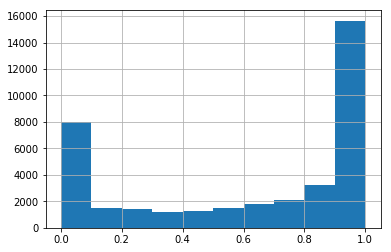

In [26]:
domains_df.script.hist()

In [29]:
domains_df.host_tld.nunique()

2159

In [30]:
domains_df[domains_df.bad_qs > 0.1].host_tld.nunique()

292

In [32]:
companies_df = pd.concat([
    pd.read_csv(file, parse_dates=['month'])
    for file in asset_paths['companies']
])
sites_df = pd.concat([
    pd.read_csv(file, parse_dates=['month'])
    for file in asset_paths['sites']
])
sites_trackers_df = pd.concat([
    pd.read_csv(file, parse_dates=['month'])
    for file in asset_paths['sites_trackers']
])
trackers_df = pd.concat([
    pd.read_csv(file, parse_dates=['month'])
    for file in asset_paths['trackers']
])

/home/bird/miniconda3/envs/whotracksme/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
/home/bird/miniconda3/envs/whotracksme/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
/home/bird/miniconda3/envs/whotracksme/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change

In [50]:
# companies.csv: Top companies - aggregates the stats for trackers owned by the same company.
companies_df[['company', 'country', 'site_reach']].head()

,company,country,site_reach
0,google,fr,0.933463
1,facebook,fr,0.386542
2,amazon_associates,fr,0.171766
3,at_internet,fr,0.026337
4,criteo,fr,0.047971


In [52]:
# sites.csv: Stats for number of trackers seen on popular websites.
sites_df[['category', 'country', 'site', 'tracker']].head()

,category,country,site,tracker
0,NaN,fr,google.fr,gstatic
1,NaN,fr,google.com,gstatic
2,NaN,fr,youtube.com,gstatic
3,NaN,fr,voirfilms.ws,gstatic
4,NaN,fr,xvideos.com,gstatic


In [51]:
# site_trackers.csv: Stats for each tracker on each site.
sites_trackers_df[['country', 'site', 'tracker']].head()

,country,site,tracker
0,fr,google.fr,gstatic
1,fr,google.com,gstatic
2,fr,youtube.com,gstatic
3,fr,voirfilms.ws,gstatic
4,fr,xvideos.com,gstatic


In [49]:
# trackers.csv: Top trackers - this combines domains known be operated by the same tracker.
trackers_df[['country', 'site', 'tracker']].head()

,country,site,tracker
0,fr,google.fr,gstatic
1,fr,google.com,gstatic
2,fr,youtube.com,gstatic
3,fr,voirfilms.ws,gstatic
4,fr,xvideos.com,gstatic


In [48]:
# domains.csv: Top third-party domains seen tracking.
domains_df[['country', 'host_tld']].head()

,country,host_tld
0,fr,google-analytics.com
1,fr,gstatic.com
2,fr,googleapis.com
3,fr,google.com
4,fr,doubleclick.net


In [53]:
len(domains_df)

37564

In [54]:
len(trackers_df)

1599663

In [62]:
len(tracker_info['trackers'])

1325

In [63]:
trackers_df.tracker.nunique()

1143

In [68]:
tracker_info['trackers']['gstatic']

{'id': 'gstatic',
 'name': 'Google Static',
 'category': 'cdn',
 'website_url': None,
 'ghostery_id': None,
 'company_id': 'google',
 'iab_vendor': None,
 'truste_type': None,
 'description': None,
 'privacy_url': 'http://www.google.com/intl/en/policies/privacy/',
 'domains': ['gstatic.com']}

In [76]:
domains_df[domains_df.bad_qs > 0.1].host_tld.nunique()

292

In [77]:
trackers_df[trackers_df.bad_qs > 0.1].site.nunique()

9145

In [94]:
trackers_df[trackers_df.site == 'drudgereport.com'].tracker.value_counts()

quantcast              41
bing_ads               35
twitter                35
yahoo                  32
googleapis.com         32
quantcount             31
gstatic                30
google                 24
cloudflare             19
google_fonts           15
kaspersky-labs.com     13
flickr_badge           11
pinterest               8
wordpress_stats         8
facebook                7
dailymail.co.uk         6
wikimedia.org           5
taboola                 4
amazon_associates       3
pagefair                2
digitrust               2
youtube                 2
amazon_cdn              2
iab_consent             2
facebook_cdn            2
index_exchange_         1
openx                   1
nyt.com                 1
the_guardian            1
the_weather_company     1
ziff_davis              1
bbci                    1
criteo                  1
amazon_web_services     1
Name: tracker, dtype: int64

In [90]:
(list(trackers_df[trackers_df.bad_qs > 0.1].site.unique()))

['easybourse.com',
 'canal-plus.com',
 'sofinco.fr',
 'aliexpress.com',
 'sephora.fr',
 'darty.com',
 'vente-privee.com',
 'rs-online.com',
 'boulanger.com',
 'zalando.fr',
 'urlauctioneer.com',
 'hollisterco.com',
 'gearbest.com',
 'lequipe.fr',
 'leparisien.fr',
 'rugbyrama.fr',
 '750g.com',
 'sportetstyle.fr',
 'motorsport.com',
 'francefootball.fr',
 'femmesplus.fr',
 'mundodeportivo.com',
 'republicain-lorrain.fr',
 'boredpanda.com',
 'lalsace.fr',
 'elperiodico.com',
 'blog-rct.com',
 'leroymerlin.fr',
 'castorama.fr',
 'son-video.com',
 'norauto.fr',
 'vertbaudet.fr',
 'uniqlo.com',
 'kingoloto.com',
 'ibm.com',
 'vistaprint.fr',
 'adidas.fr',
 'redbubble.com',
 'mangahere.cc',
 'basketusa.com',
 'avxhm.se',
 'mangatown.com',
 'pof.com',
 'twitter.com',
 'googleusercontent.com',
 'explorimmo.com',
 'cadremploi.fr',
 'perlesandco.com',
 'axabanque.fr',
 'cultureindoor.com',
 'axa.fr',
 'quintonic.fr',
 'dieti-natura.com',
 'huffingtonpost.fr',
 'rtl.fr',
 'lesinrocks.com',
 'chro

In [81]:
sites_df.tracker.nunique()

1140

In [82]:
sites_trackers_df.tracker.nunique()

1140

In [110]:
fingerprinting_trackers = sorted(list(domains_df[domains_df.bad_qs > 0.1].host_tld.unique()))
fingerprinting_trackers[0:5]

['247-inc.net', '2o7.net', '33across.com', '51.la', 'aamsitecertifier.com']

In [111]:
len(fingerprinting_trackers)

292

In [114]:
with open('/home/bird/Dev/mozilla/overscripted-clustering/tests/whotracksme/fingerprinting_trackers.json', 'w') as f:
    f.write(json.dumps(fingerprinting_trackers))

In [129]:
regions

{'de', 'eu', 'fr', 'global', 'us'}

In [134]:
fp_trackers = set()
for region in regions:
    who_tracks_data = DataSource(region=region)
    who_tracks_fp = who_tracks_data.trackers.df[who_tracks_data.trackers.df.bad_qs > 0.1]
    print(region, who_tracks_fp.tracker.nunique())
    fp_trackers.update(list(who_tracks_fp.tracker.values))

data available for months:
├── 2018-04
├── 2018-05
├── 2018-06
├── 2018-07
├── 2018-08
├── 2018-09


/home/bird/Dev/misc-clones/whotracks.me/whotracksme/data/loader.py:99: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  for month in data_months


fr 12
data available for months:
├── 2018-04
├── 2018-05
├── 2018-06
├── 2018-07
├── 2018-08
├── 2018-09
de 39
data available for months:
├── 2018-03
├── 2018-04
├── 2018-05
├── 2018-06
├── 2018-07
├── 2018-08
├── 2018-09
eu 64
data available for months:
├── 2018-04
├── 2018-05
├── 2018-06
├── 2018-07
├── 2018-08
├── 2018-09
us 32
data available for months:
├── 2017-05
├── 2017-06
├── 2017-07
├── 2017-08
├── 2017-09
├── 2017-10
├── 2017-11
├── 2017-12
├── 2018-01
├── 2018-02
├── 2018-03
├── 2018-04
├── 2018-05
├── 2018-06
├── 2018-07
├── 2018-08
├── 2018-09
global 186


In [135]:
len(fp_trackers)

193

In [145]:
np.all(who_tracks_fp.id == who_tracks_fp.tracker)

True

This is less than what we ended up with when we built data ourselves.

Bit there we were building hosts.

In [151]:
tracker_info['trackers'][list(fp_trackers)[33]]

{'id': 'infonline',
 'name': 'INFOnline',
 'category': 'site_analytics',
 'website_url': 'http://www.infonline.de/',
 'ghostery_id': '223',
 'company_id': 'infonline',
 'iab_vendor': None,
 'truste_type': None,
 'description': None,
 'privacy_url': 'https://www.infonline.de/datenschutz/',
 'domains': ['ioam.de', 'iocnt.net', 'ivwbox.de']}

In [154]:
could_not_find = []
domains = set()
for tracker in fp_trackers:
    try:
        domains.update(tracker_info['trackers'][tracker]['domains'])
    except KeyError:
        could_not_find.append(tracker)

In [156]:
could_not_find

['marketgrid']

In [157]:
len(list(domains))

326